# Notebook to experiment with testing:

## Code:

In [1]:
import numpy as np
import random
import os
import torch
from gymnasium import spaces

SEED = 42
# Python RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch RNG (CPU + GPU)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [2]:
from training_environments import prepare, Glioblastoma, Glioblastoma2
from training_dqn import DQN, DQN2, DQN3, DQN4, DQN5
from training_agents import DQNAgent, DQNAgent2
from training_buffers import ReplayBuffer

In [3]:
test_pairs = prepare(mode='test')

✅ Found 100 pairs out of 100 listed in CSV.


# TESTING:

In [4]:
def test_agent_current(agent, test_pairs, num_episodes=10, print_results=True, env_config=None):
    """
    Test the trained agent using the current environment setup
    without any modifications to reward system or early termination
    """
    agent.dnnetwork.eval()  # Set to evaluation mode
    
    metrics = {
        'success_rate': [],
        'final_position_accuracy': [],
        'average_reward': [],
        'steps_to_find_tumor': [],
        'tumor_coverage': [],
        'total_tumor_reward': []
    }
    
    grid_size, rewards, action_space = env_config['grid_size'], env_config['rewards'], env_config['action_space']
    
    for i in range(num_episodes):
        img_path, mask_path = test_pairs[i]
        env = Glioblastoma2(img_path, mask_path, grid_size=grid_size, rewards=rewards, action_space=action_space)
        
        state, _ = env.reset()
        total_reward = 0
        found_tumor = False
        tumor_positions_visited = set()
        steps_to_find = env.max_steps  # Default: didn't find
        tumor_rewards = 0
        
        for step in range(env.max_steps):
            with torch.no_grad():
                action = agent.dnnetwork.get_action(state, epsilon=0.00)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward
            
            # Track tumor-related metrics
            current_overlap = env.current_patch_overlap_with_lesion()
            if current_overlap > 0:
                tumor_positions_visited.add(tuple(env.agent_pos))
                if not found_tumor:
                    found_tumor = True
                    steps_to_find = step + 1
                
                # Count positive rewards (when on tumor)
                if reward > 0:
                    tumor_rewards += 1
        
        # Calculate metrics for this episode
        final_overlap = env.current_patch_overlap_with_lesion()
        
        # Success: ended on tumor region
        success = final_overlap > 0
        metrics['success_rate'].append(success)
        
        # Final position accuracy
        metrics['final_position_accuracy'].append(final_overlap > 0)
        
        # Average reward
        metrics['average_reward'].append(total_reward)
        
        # Steps to find tumor
        metrics['steps_to_find_tumor'].append(steps_to_find)
        
        # Tumor coverage (percentage of tumor patches visited)
        total_tumor_patches = count_tumor_patches(env)
        coverage = len(tumor_positions_visited) / total_tumor_patches if total_tumor_patches > 0 else 0
        metrics['tumor_coverage'].append(coverage)
        
        # Total positive rewards from tumor
        metrics['total_tumor_reward'].append(tumor_rewards)
    
    # Calculate and print final results
    if print_results:
        print("\n" + "="*50)
        print("TEST RESULTS (Current Model)")
        print("="*50)
        print(f"Success Rate: {np.mean(metrics['success_rate'])*100:.2f}%")
        print(f"Final Position Accuracy: {np.mean(metrics['final_position_accuracy'])*100:.2f}%")
        print(f"Average Episode Reward: {np.mean(metrics['average_reward']):.2f}")
        print(f"Average Steps to Find Tumor: {np.mean(metrics['steps_to_find_tumor']):.2f}")
        print(f"Average Tumor Coverage: {np.mean(metrics['tumor_coverage'])*100:.2f}%")
        print(f"Average Tumor Rewards per Episode: {np.mean(metrics['total_tumor_reward']):.2f}")
        
        # Additional detailed statistics
        print("\nDetailed Statistics:")
        print(f"Best Episode Reward: {np.max(metrics['average_reward']):.2f}")
        print(f"Worst Episode Reward: {np.min(metrics['average_reward']):.2f}")
        print(f"Median Steps to Find Tumor: {np.median(metrics['steps_to_find_tumor']):.2f}")
    
    return metrics

def count_tumor_patches(env):
    """Count total number of patches that contain tumor"""
    tumor_patches = 0
    original_pos = env.agent_pos.copy()  # Save original position
    
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            env.agent_pos = [i, j]
            if env.current_patch_overlap_with_lesion() > 0:
                tumor_patches += 1
    
    env.agent_pos = original_pos  # Restore original position
    return tumor_patches

def visualize_test_episode(agent, img_path, mask_path, episode_num=0):
    """Visualize a single test episode"""
    env = Glioblastoma2(img_path, mask_path, grid_size=4)
    state, _ = env.reset()
    
    positions = []
    actions = []
    rewards = []
    episode_reward = 0
    tumor_found = False
    
    print(f"\nVisualizing Test Episode {episode_num}")
    print("Image:", os.path.basename(img_path))
    
    for step in range(env.max_steps):
        with torch.no_grad():
            action = agent.dnnetwork.get_action(state, epsilon=0.01)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        positions.append(env.agent_pos.copy())
        actions.append(action)
        rewards.append(reward)
        
        # Check tumor status
        current_overlap = env.current_patch_overlap_with_lesion()
        if current_overlap > 0 and not tumor_found:
            tumor_found = True
            print(f"  Step {step+1}: Found tumor at position {env.agent_pos}")
        
        state = next_state
        
        # Render every step or at important moments
        if step == 0 or tumor_found or step == env.max_steps - 1:
            env.render()
    
    final_overlap = env.current_patch_overlap_with_lesion()
    print(f"Final position: {env.agent_pos}, On tumor: {final_overlap > 0}")
    print(f"Total reward: {sum(rewards):.2f}")
    
    print("\nStep-by-step rewards:")
    for idx, (pos, act, rew) in enumerate(zip(positions, actions, rewards)):
        print(f"  Step {idx+1}: Position {pos}, Action {act}, Reward {rew}")


In [10]:
# for name, param in model.named_parameters():
#     if 'fc' in name and 'weight' in name:
#         print(f"Weights of layer {name}:")
#         print(param.data)
#         break  # print only the first fc layer weights

# for name, param in model2.named_parameters():
#     if 'fc' in name and 'weight' in name:
#         print(f"Weights of layer {name}:")
#         print(param.data)
#         break  # print only the first fc layer weights

In [ ]:
# load model to test:
LR = 1e-4 #From paper
CURRENT_CONFIG = {
    'grid_size': 4,
    'rewards': [5.0, -1.0, -0.2], 
    'action_space': spaces.Discrete(3)
}

env = Glioblastoma2(*test_pairs[0], **CURRENT_CONFIG)

model = DQN4(env, learning_rate=LR, device='cpu')
model.load_state_dict(torch.load("Extension014.dat"))

agent = DQNAgent2(env_config=CURRENT_CONFIG, dnnetwork=model, buffer_class=ReplayBuffer, train_pairs=test_pairs,
                 env_class=Glioblastoma2,
                 epsilon=0.00)  # very low epsilon for testing


metrics1 = test_agent_current(agent, test_pairs, num_episodes=len(test_pairs), env_config=CURRENT_CONFIG)


TEST RESULTS (Current Model)
Success Rate: 8.00%
Final Position Accuracy: 8.00%
Average Episode Reward: -12.05
Average Steps to Find Tumor: 18.48
Average Tumor Coverage: 1.79%
Average Tumor Rewards per Episode: 1.20

Detailed Statistics:
Best Episode Reward: 100.00
Worst Episode Reward: -19.20
Median Steps to Find Tumor: 20.00



Visualizing Test Episode 1
Image: 002_58.npy


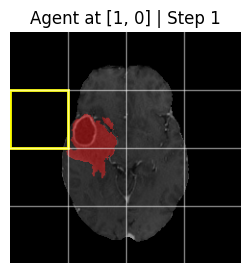

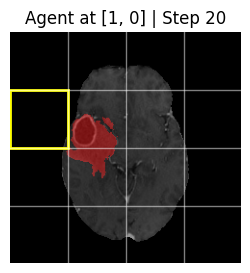

Final position: [1, 0], On tumor: False
Total reward: -38.50

Step-by-step rewards:
  Step 1: Position [1, 0], Action 1, Reward -0.5
  Step 2: Position [1, 0], Action 0, Reward -2.0
  Step 3: Position [1, 0], Action 0, Reward -2.0
  Step 4: Position [1, 0], Action 0, Reward -2.0
  Step 5: Position [1, 0], Action 0, Reward -2.0
  Step 6: Position [1, 0], Action 0, Reward -2.0
  Step 7: Position [1, 0], Action 0, Reward -2.0
  Step 8: Position [1, 0], Action 0, Reward -2.0
  Step 9: Position [1, 0], Action 0, Reward -2.0
  Step 10: Position [1, 0], Action 0, Reward -2.0
  Step 11: Position [1, 0], Action 0, Reward -2.0
  Step 12: Position [1, 0], Action 0, Reward -2.0
  Step 13: Position [1, 0], Action 0, Reward -2.0
  Step 14: Position [1, 0], Action 0, Reward -2.0
  Step 15: Position [1, 0], Action 0, Reward -2.0
  Step 16: Position [1, 0], Action 0, Reward -2.0
  Step 17: Position [1, 0], Action 0, Reward -2.0
  Step 18: Position [1, 0], Action 0, Reward -2.0
  Step 19: Position [1, 0

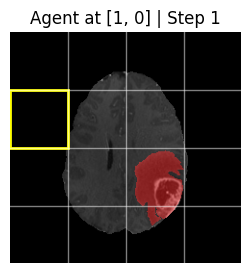

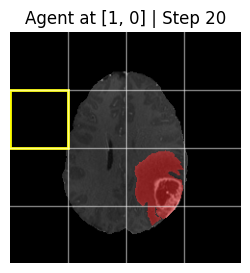

Final position: [1, 0], On tumor: False
Total reward: -38.50

Step-by-step rewards:
  Step 1: Position [1, 0], Action 1, Reward -0.5
  Step 2: Position [1, 0], Action 0, Reward -2.0
  Step 3: Position [1, 0], Action 0, Reward -2.0
  Step 4: Position [1, 0], Action 0, Reward -2.0
  Step 5: Position [1, 0], Action 0, Reward -2.0
  Step 6: Position [1, 0], Action 0, Reward -2.0
  Step 7: Position [1, 0], Action 0, Reward -2.0
  Step 8: Position [1, 0], Action 0, Reward -2.0
  Step 9: Position [1, 0], Action 0, Reward -2.0
  Step 10: Position [1, 0], Action 0, Reward -2.0
  Step 11: Position [1, 0], Action 0, Reward -2.0
  Step 12: Position [1, 0], Action 0, Reward -2.0
  Step 13: Position [1, 0], Action 0, Reward -2.0
  Step 14: Position [1, 0], Action 0, Reward -2.0
  Step 15: Position [1, 0], Action 0, Reward -2.0
  Step 16: Position [1, 0], Action 0, Reward -2.0
  Step 17: Position [1, 0], Action 0, Reward -2.0
  Step 18: Position [1, 0], Action 0, Reward -2.0
  Step 19: Position [1, 0

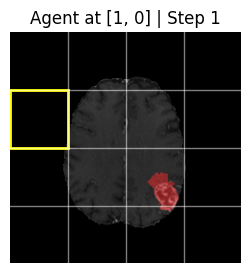

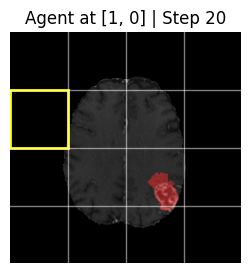

Final position: [1, 0], On tumor: False
Total reward: -38.50

Step-by-step rewards:
  Step 1: Position [1, 0], Action 1, Reward -0.5
  Step 2: Position [1, 0], Action 0, Reward -2.0
  Step 3: Position [1, 0], Action 0, Reward -2.0
  Step 4: Position [1, 0], Action 0, Reward -2.0
  Step 5: Position [1, 0], Action 0, Reward -2.0
  Step 6: Position [1, 0], Action 0, Reward -2.0
  Step 7: Position [1, 0], Action 0, Reward -2.0
  Step 8: Position [1, 0], Action 0, Reward -2.0
  Step 9: Position [1, 0], Action 0, Reward -2.0
  Step 10: Position [1, 0], Action 0, Reward -2.0
  Step 11: Position [1, 0], Action 0, Reward -2.0
  Step 12: Position [1, 0], Action 0, Reward -2.0
  Step 13: Position [1, 0], Action 0, Reward -2.0
  Step 14: Position [1, 0], Action 0, Reward -2.0
  Step 15: Position [1, 0], Action 0, Reward -2.0
  Step 16: Position [1, 0], Action 0, Reward -2.0
  Step 17: Position [1, 0], Action 0, Reward -2.0
  Step 18: Position [1, 0], Action 0, Reward -2.0
  Step 19: Position [1, 0

In [9]:
for i in range(3):  # visualize 3 test episodes
    visualize_test_episode(agent, test_pairs[i][0], test_pairs[i][1], episode_num=1)